In [403]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
#from teaching_tools.widgets import ConfusionMatrixWidget

In [404]:
loan_data = pd.read_csv("loan_default.csv")
loan_data.head()


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1,@
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0,NaN
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0,NaN
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0,NaN
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0,NaN


In [405]:
loan = loan_data.copy()

In [406]:
loan.drop(['ID', 'year', '@'], axis = 1, inplace = True)

In [407]:
numeric= loan.select_dtypes(include = ['number'])
correlation = numeric.drop(columns = 'Status').corr()

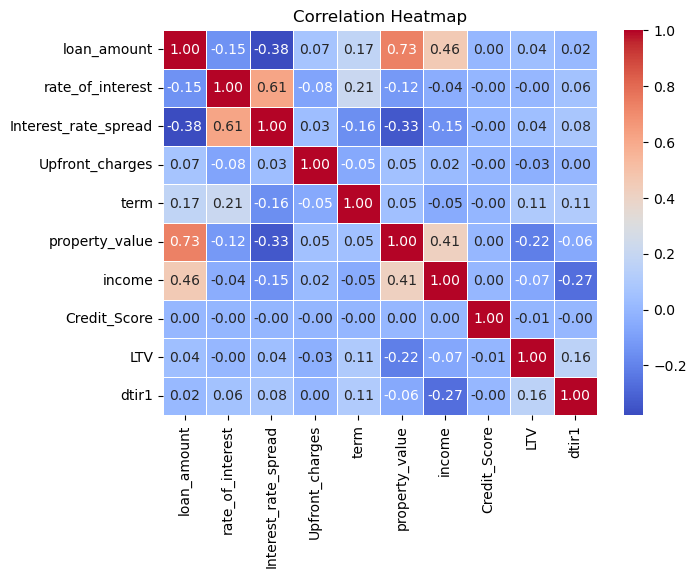

In [408]:
plt.figure(figsize=(7, 5))  # Adjust size as needed
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [409]:
loan.drop(columns = ['property_value', 'Interest_rate_spread'], axis = 1, inplace = True)

In [410]:
loan.select_dtypes(include = ['number']).isna().sum()

loan_amount             0
rate_of_interest    36439
Upfront_charges     39642
term                   41
income               9150
Credit_Score            0
LTV                 15098
Status                  0
dtir1               24121
dtype: int64

In [411]:
loan.select_dtypes(include = ['object']).isna().sum()

loan_limit                   3344
Gender                          0
approv_in_adv                 908
loan_type                       0
loan_purpose                  134
Credit_Worthiness               0
open_credit                     0
business_or_commercial          0
Neg_ammortization             121
interest_only                   0
lump_sum_payment                0
construction_type               0
occupancy_type                  0
Secured_by                      0
total_units                     0
credit_type                     0
co-applicant_credit_type        0
age                           200
submission_of_application     200
Region                          0
Security_Type                   0
dtype: int64

In [412]:
loan['age'].value_counts(normalize = True)

age
45-54    0.233852
35-44    0.221041
55-64    0.219128
65-74    0.139718
25-34    0.128928
>74      0.048326
<25      0.009005
Name: proportion, dtype: float64

In [413]:
loan = loan[loan['age'].notna()]

In [414]:
category = loan.select_dtypes(include = ['object'])

In [415]:
category.nunique()

loan_limit                   2
Gender                       4
approv_in_adv                2
loan_type                    3
loan_purpose                 4
Credit_Worthiness            2
open_credit                  2
business_or_commercial       2
Neg_ammortization            2
interest_only                2
lump_sum_payment             2
construction_type            2
occupancy_type               3
Secured_by                   2
total_units                  4
credit_type                  4
co-applicant_credit_type     2
age                          7
submission_of_application    2
Region                       4
Security_Type                2
dtype: int64

#### Regrouping age to reduce cardinality

In [416]:
# Reducing age cardinality from 7 to 5 to reduce columns size during preprocessing
group_mapping = {
    "45-54": "35-54",
    "35-44": "35-54",
    "55-64": "55-74",
    "65-74": "55-74",
    "25-34": "25-34",
    ">74": "75+",
    "<25": "Under 25"
}

# Apply the mapping to the 'age' column
loan['age'] = loan['age'].map(group_mapping)

# Check if mapping was successful
print(loan['age'].value_counts())  # To verify new groups




age
35-54       67538
55-74       53278
25-34       19142
75+          7175
Under 25     1337
Name: count, dtype: int64


In [417]:
loan.select_dtypes(include = 'object').nunique()

loan_limit                   2
Gender                       4
approv_in_adv                2
loan_type                    3
loan_purpose                 4
Credit_Worthiness            2
open_credit                  2
business_or_commercial       2
Neg_ammortization            2
interest_only                2
lump_sum_payment             2
construction_type            2
occupancy_type               3
Secured_by                   2
total_units                  4
credit_type                  4
co-applicant_credit_type     2
age                          5
submission_of_application    2
Region                       4
Security_Type                2
dtype: int64

#### Removing redundant variables Among Categorical Variables

In [418]:
for col in category:
    unique = loan[col].value_counts(normalize = True)
    print(unique, '\n')
    print('*'*20)

loan_limit
cf     0.932423
ncf    0.067577
Name: proportion, dtype: float64 

********************
Gender
Male                 0.285216
Joint                0.278837
Sex Not Available    0.252300
Female               0.183647
Name: proportion, dtype: float64 

********************
approv_in_adv
nopre    0.843185
pre      0.156815
Name: proportion, dtype: float64 

********************
loan_type
type1    0.762019
type2    0.138769
type3    0.099212
Name: proportion, dtype: float64 

********************
loan_purpose
p3    0.376631
p4    0.369182
p1    0.232143
p2    0.022043
Name: proportion, dtype: float64 

********************
Credit_Worthiness
l1    0.957392
l2    0.042608
Name: proportion, dtype: float64 

********************
open_credit
nopc    0.996255
opc     0.003745
Name: proportion, dtype: float64 

********************
business_or_commercial
nob/c    0.861231
b/c      0.138769
Name: proportion, dtype: float64 

********************
Neg_ammortization
not_neg    0.898887
neg_

In [419]:
'''
Using 95% as a threshold for class imbalane: Any Categorical variables that has a factor thas is 95% 
among other factors within the same variable, then we conclude that other factors may not have any 
predicting power to the model. Therefore remove such variable from the model
'''
categorical_features= loan.select_dtypes(include = ['object']).columns.tolist()

high_imbalance_features = []
low_imbalance_features = []

for feature in categorical_features:
    unique = loan[feature].value_counts(normalize=True)
    if unique.max() > 0.95:
        high_imbalance_features.append(feature)
    else:
        low_imbalance_features.append(feature)


In [420]:
loan.drop(columns = high_imbalance_features, axis = 1, inplace = True)

In [421]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148470 entries, 0 to 148669
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 145138 non-null  object 
 1   Gender                     148470 non-null  object 
 2   approv_in_adv              147562 non-null  object 
 3   loan_type                  148470 non-null  object 
 4   loan_purpose               148344 non-null  object 
 5   business_or_commercial     148470 non-null  object 
 6   loan_amount                148470 non-null  int64  
 7   rate_of_interest           112031 non-null  float64
 8   Upfront_charges            108875 non-null  float64
 9   term                       148429 non-null  float64
 10  Neg_ammortization          148349 non-null  object 
 11  occupancy_type             148470 non-null  object 
 12  income                     139520 non-null  float64
 13  credit_type                148470 

In [422]:
def count_features(data):
    #Getting column with objects dtype
    objects= loan.select_dtypes(include=['object']).columns
    numerical= loan.select_dtypes(include=['number']).columns
    
    print('Numerical features are :',len(numerical))
    print('Objects features are  :',len(objects))

In [423]:
count_features(loan)

Numerical features are : 9
Objects features are  : 13


In [424]:
X = loan.drop(['Status'], axis = 1)
y = loan['Status']
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size = 0.2, random_state = 42)

In [425]:
y.value_counts()

Status
0    112031
1     36439
Name: count, dtype: int64

In [426]:
num_features = X.select_dtypes(include=['number']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Define transformers for numerical and categorical data
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),                   # Scale numerical data
    ('imputer', SimpleImputer(strategy='median'))  # Handle missing values for numerical data                  
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values for categorical data
    ('onehot', OneHotEncoder(handle_unknown='ignore'))                     # One-hot encode categorical data
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),   # Apply numerical transformer
        ('cat', cat_transformer, cat_features)   # Apply categorical transformer
    ]
)
print(preprocessor)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['loan_amount', 'rate_of_interest', 'Upfront_charges', 'term', 'income',
       'Credit_Score', 'LTV', 'dtir1'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'business_or_

In [427]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.fit_transform(X_test)

### Model with imbalanced dataset

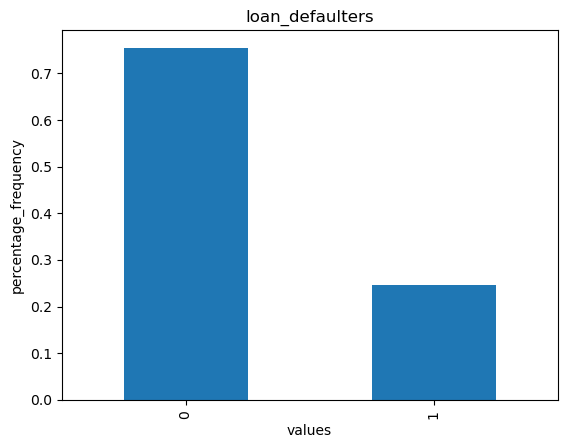

In [428]:
loan["Status"].value_counts(normalize = True).plot(
    kind = "bar",
    xlabel = "values",
    ylabel = "percentage_frequency",
    title = "loan_defaulters"
);

In [429]:
print("X_train_resampled shape:", X_train_preprocessed.shape)
print("y_train_resampled shape:", y_train.shape)
print("X_test shape:", X_test_preprocessed.shape)
print("y_test shape:", y_test.shape)


X_train_resampled shape: (118776, 51)
y_train_resampled shape: (118776,)
X_test shape: (29694, 51)
y_test shape: (29694,)


In [430]:
lg = LogisticRegression(max_iter=1000)
lg.fit(X_train_preprocessed, y_train)

LogisticRegression(max_iter=1000)

In [431]:
Rfc = RandomForestClassifier(random_state=42)
Rfc.fit(X_train_preprocessed, y_train)

RandomForestClassifier(random_state=42)

In [432]:
y_pred_Rfc = Rfc.predict(X_test_preprocessed)
y_pred_lg = lg.predict(X_test_preprocessed)

#### Evaluate our Models with class imbalance

In [433]:
y_test.value_counts()

Status
0    22521
1     7173
Name: count, dtype: int64

In [434]:
# Evaluating the baselince accuracy of the dataset
base_acc = loan["Status"].value_counts(normalize = True).max()
print("baseline accuracy:", base_acc )

baseline accuracy: 0.7545699467905974


In [435]:
acc_train = accuracy_score(y_train, lg.predict(X_train_preprocessed))
acc_test = lg.score(X_test_preprocessed, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.86
Test Accuracy: 0.87


In [436]:
acc_train = accuracy_score(y_train, Rfc.predict(X_train_preprocessed))
acc_test = Rfc.score(X_test_preprocessed, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 1.0
Test Accuracy: 0.84


In [437]:
# Generate the classification report
report_Rfc = classification_report(y_test, y_pred_Rfc)

# Generate the classification report
report_lg = classification_report(y_test, y_pred_lg)

# Print the classification report
print('Randomforest report:')
print(report_Rfc)
print('logistic regression report:')
print(report_lg)

Randomforest report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     22521
           1       1.00      0.33      0.50      7173

    accuracy                           0.84     29694
   macro avg       0.91      0.67      0.70     29694
weighted avg       0.87      0.84      0.81     29694

logistic regression report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     22521
           1       0.95      0.46      0.63      7173

    accuracy                           0.87     29694
   macro avg       0.90      0.73      0.77     29694
weighted avg       0.88      0.87      0.85     29694



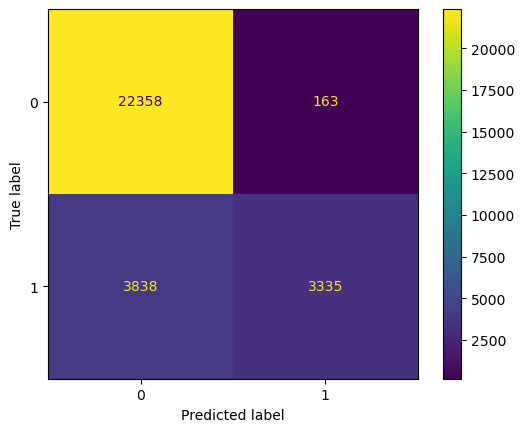

In [438]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(lg, X_test_preprocessed, y_test);

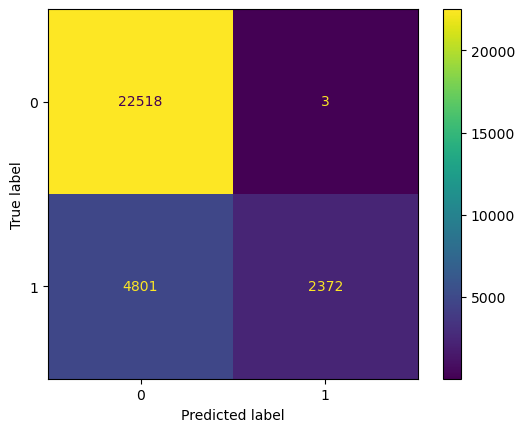

In [439]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(Rfc, X_test_preprocessed, y_test);

### Retraining Model with a balanced set (using Smote )

In [440]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

In [441]:
print("X_train_resampled shape:", X_train_resampled.shape)
print("y_train_resampled shape:", y_train_resampled.shape)
print("X_test shape:", X_test_preprocessed.shape)
print("y_test shape:", y_test.shape)


X_train_resampled shape: (179020, 51)
y_train_resampled shape: (179020,)
X_test shape: (29694, 51)
y_test shape: (29694,)


In [442]:
y_train_resampled.value_counts()

Status
1    89510
0    89510
Name: count, dtype: int64

In [443]:
lg = LogisticRegression(max_iter=1000)
lg.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

In [444]:
Rfc = RandomForestClassifier(random_state=42)
Rfc.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [445]:
y_pred_lg = lg.predict(X_test_preprocessed)
y_prob_lg = lg.predict_proba(X_test_preprocessed)[:, 1]

In [446]:
y_Rfc_pred = Rfc.predict(X_test_preprocessed)
y_Rfc_prob = Rfc.predict_proba(X_test_preprocessed)[:,1]

#### Evaluate our models after class balance


In [447]:
y_test.value_counts()

Status
0    22521
1     7173
Name: count, dtype: int64

In [448]:
# Evaluating the baselince accuracy of the dataset
base_acc = loan["Status"].value_counts(normalize = True).max()
print("baseline accuracy:", base_acc )

baseline accuracy: 0.7545699467905974


In [449]:
acc_train = accuracy_score(y_train_resampled, lg.predict(X_train_resampled))
acc_test = lg.score(X_test_preprocessed, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.78
Test Accuracy: 0.82


In [450]:
acc_train = accuracy_score(y_train_resampled, Rfc.predict(X_train_resampled))
acc_test = Rfc.score(X_test_preprocessed, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 1.0
Test Accuracy: 0.86


In [451]:
# Generate the classification report
report_lg = classification_report(y_test, y_pred_lg)

# Generate the classification report
report_Rfc = classification_report(y_test, y_Rfc_pred)

# Print the classification report
print("logistic regression report:")
print(report_lg)
print('Random forest report:')
print(report_Rfc)

logistic regression report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     22521
           1       0.63      0.65      0.64      7173

    accuracy                           0.82     29694
   macro avg       0.76      0.77      0.76     29694
weighted avg       0.83      0.82      0.83     29694

Random forest report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     22521
           1       1.00      0.43      0.60      7173

    accuracy                           0.86     29694
   macro avg       0.92      0.71      0.76     29694
weighted avg       0.88      0.86      0.84     29694



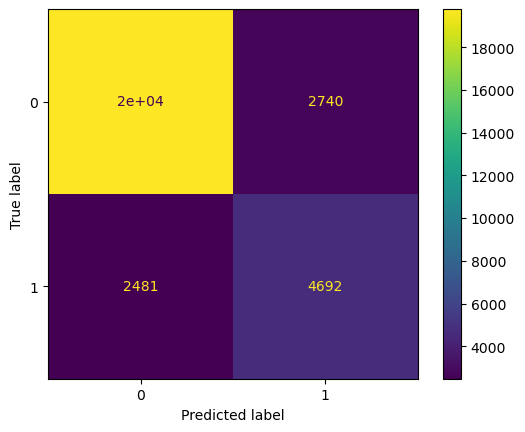

In [452]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(lg, X_test_preprocessed, y_test);

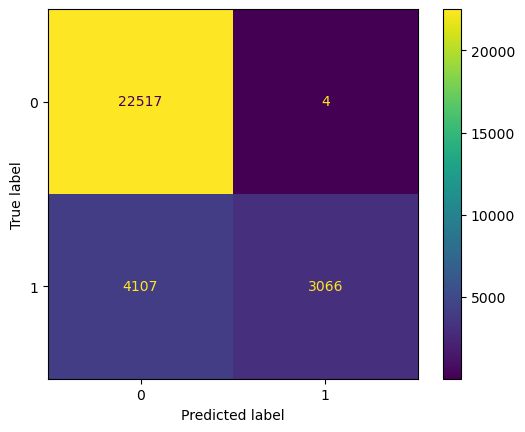

In [453]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(Rfc, X_test_preprocessed, y_test);

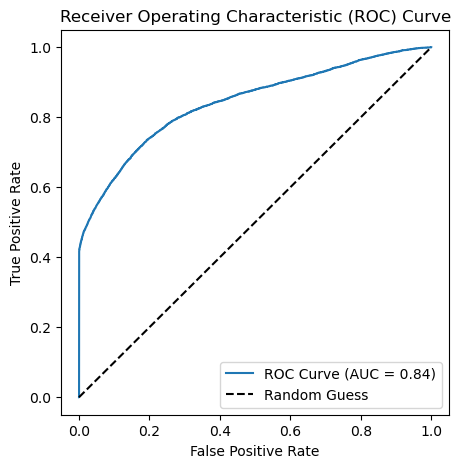

In [454]:
# The Roc metric
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lg)
auc_score = roc_auc_score(y_test, y_prob_lg)

# Plot the ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

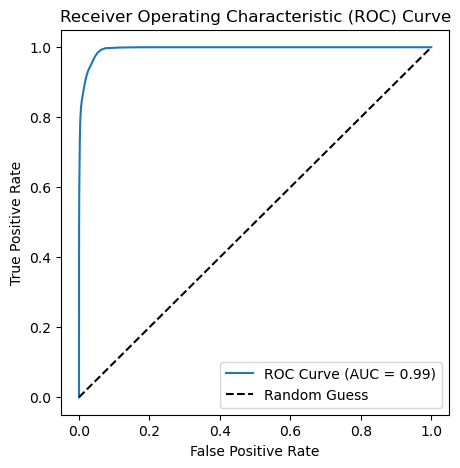

In [455]:
fpr, tpr, thresholds = roc_curve(y_test, y_Rfc_prob)
auc_score = roc_auc_score(y_test, y_Rfc_prob)

# Plot the ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#### Feature Importance

In [456]:
# Numerical feature names
num_feature_names = num_features.tolist()

# Categorical feature names (after one-hot encoding)
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features)

# Combine numerical and categorical feature names
all_feature_names = num_feature_names + list(cat_feature_names)


In [457]:
# Get feature coefficients
coefficients = lg.coef_[0]

# Pair features with their coefficients
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})


In [458]:
# Sort by absolute value of coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display top 10 features
print(feature_importance.head(10))


                              Feature  Coefficient  Abs_Coefficient
36                   credit_type_EQUI    12.550122        12.550122
37                    credit_type_EXP    -3.995241         3.995241
34                    credit_type_CIB    -3.951560         3.951560
35                   credit_type_CRIF    -3.925752         3.925752
46  submission_of_application_to_inst     0.975065         0.975065
31                  occupancy_type_ir     0.883693         0.883693
23                    loan_purpose_p2     0.835196         0.835196
29          Neg_ammortization_neg_amm     0.785309         0.785309
10                     loan_limit_ncf     0.726934         0.726934
2                     Upfront_charges    -0.707635         0.707635


C:\Users\admin\AppData\Local\Temp\ipykernel_24288\3573635629.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


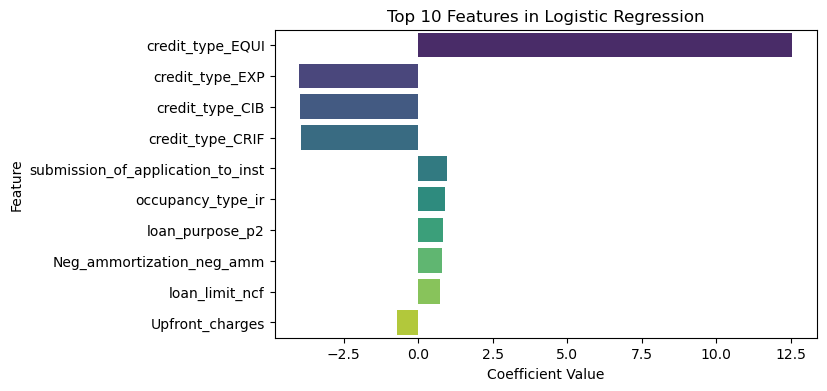

In [459]:
# Plot top features
plt.figure(figsize=(7, 4))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=feature_importance.head(10),
    palette='viridis'
)
plt.title('Top 10 Features in Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_24288\542204183.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


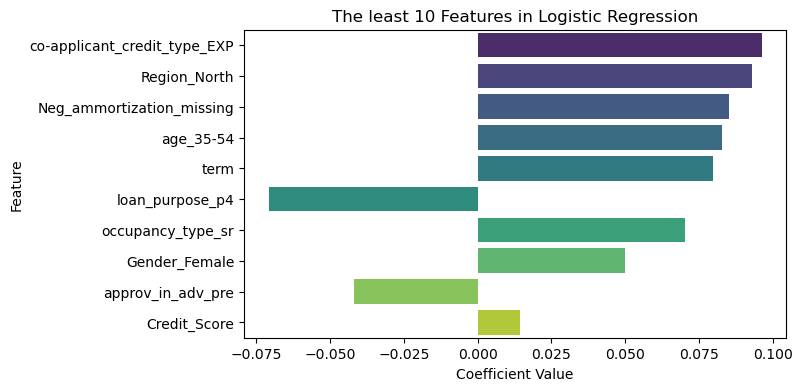

In [460]:
# Plot top features
plt.figure(figsize=(7, 4))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=feature_importance.tail(10),
    palette='viridis'
)
plt.title('The least 10 Features in Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


#### Segregation by age

In [461]:
group_results = {}

for age in loan['age'].unique():
    group_data = loan[loan['age'] == age]
    X_group = group_data.drop(columns=['Status', 'age'])
    y_group = group_data.Status

    # Identify numerical and categorical features
    num_features = X_group.select_dtypes(include=['number']).columns
    cat_features = X_group.select_dtypes(include=['object']).columns

    # Define transformers for numerical and categorical data
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Handle missing values for numerical data
        ('scaler', StandardScaler())                   # Scale numerical data
    ])

    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values for categorical data
        ('onehot', OneHotEncoder(handle_unknown='ignore'))                      # One-hot encode categorical data
    ])

    # Combine transformers into a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_features),  # Apply numerical transformer
            ('cat', cat_transformer, cat_features)  # Apply categorical transformer
        ]
    )

    # Preprocess the data
    X_group_processed = preprocessor.fit_transform(X_group)

    # Extract feature names
    num_feature_names = num_features.tolist()
    cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features)
    all_feature_names = num_feature_names + list(cat_feature_names)

    # Train model
    model = LogisticRegression(max_iter = 1000)  # Use the selected model
    model.fit(X_group_processed, y_group)

    # Feature importance using permutation importance
    perm_importance = permutation_importance(model, X_group_processed, y_group, random_state=42)
    feature_importances = pd.DataFrame(
        {'Feature': all_feature_names, 'Importance': perm_importance.importances_mean}
    ).sort_values(by='Importance', ascending=False)

    # Store results for the age group
    group_results[age] = feature_importances


In [462]:
group_results

{'25-34':                                Feature    Importance
 36                    credit_type_EQUI  9.956117e-02
 37                     credit_type_EXP  4.484380e-02
 35                    credit_type_CRIF  4.338105e-02
 34                     credit_type_CIB  4.283774e-02
 2                      Upfront_charges  9.528785e-03
 1                     rate_of_interest  9.424303e-03
 29           Neg_ammortization_neg_amm  6.039076e-03
 18                     loan_type_type1  5.600251e-03
 30           Neg_ammortization_not_neg  4.492738e-03
 6                                  LTV  4.189740e-03
 41   submission_of_application_to_inst  4.074809e-03
 40  submission_of_application_not_inst  2.904608e-03
 32                   occupancy_type_pr  2.862815e-03
 31                   occupancy_type_ir  2.204576e-03
 24                     loan_purpose_p3  1.891129e-03
 25                     loan_purpose_p4  1.629924e-03
 4                               income  1.306029e-03
 16                